In [46]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence,pad_sequence, pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter #Import tensorboard
import torch.distributions as dist
import numpy
import wget
import matplotlib.pyplot as plt
import numpy as np
from data_rnn import *
from elman_rnn import Elman

# Load data
---

In [47]:
#Load data
#Data is loaded in the form of a list of lists of integers, where each list of integers represents a sentence
#xtrain is sorted from short sequences to long sequences

#ndfa dataset
x_train_ndfa, (i2w_ndfa, w2i_ndfa) = load_ndfa(n=150_000)

#brackets dataset
x_train_brackets, (i2w_brackets, w2i_brackets) = load_brackets(n=150_000)


In [48]:
w2i_ndfa

{'.pad': 0,
 '.start': 1,
 '.end': 2,
 '.unk': 3,
 'b': 4,
 '!': 5,
 's': 6,
 'a': 7,
 'k': 8,
 'u': 9,
 'w': 10,
 'l': 11,
 'v': 12,
 'c': 13,
 'm': 14}

In [49]:
#Decoding a sequence
#The code below extracts the characters that correspond to the indices the sequence at position 10_000 of the ndfa dataset
print(''.join([i2w_ndfa[i] for i in  x_train_ndfa[149_000]]))

sklm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!klm!s


In [50]:
print(len(x_train_ndfa[75000]))

10


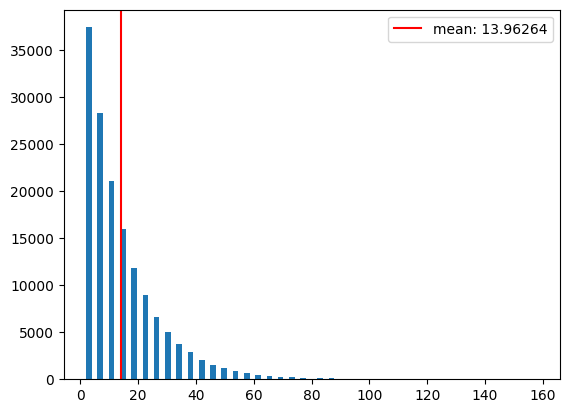

In [51]:
#Plot distribution of batch sizes for the ndfa dataset
mean = numpy.mean([len(x) for x in x_train_ndfa])
plt.hist([len(x) for x in x_train_ndfa], bins=80)

#plot mean
plt.axvline(mean, color='r', label=f'mean: {mean}' )
plt.legend()

In [52]:
#Count the number of sequences of length 10 in the ndfa dataset
print(sum([len(x) == 10 for x in x_train_ndfa]))

#Most sequences are of a shorter length than 50!!

21045


# Batching and padding
---

In [53]:
def create_batches(sequences, max_tokens):

    start = 0
    end = max_tokens
    step = 10

    # Dynamically create ranges
    ranges = [(i, i + step) for i in range(start, end, step)]
    #Create a dictionary with the keys being the sequence length ranges and the values being the sequences that fall within that range
    batches_dictionary = {range_tuple: [] for range_tuple in ranges}

    for range_tuple in ranges:
        start, end = range_tuple
        for sequence in sequences:
            if len(sequence) > start and len(sequence) <= end:
                batches_dictionary[range_tuple].append(sequence)

    return batches_dictionary


In [54]:
# big_list = [1]
# sequences = [[1,2,3],[0,2,3,4],[0,2,3,4],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1,1,1,1,1]]


# start = 0
# end = 30
# step = 10

# # Dynamically create ranges
# ranges = [(i, i + step) for i in range(start, end, step)]
# #Create a dictionary with the keys being the sequence length ranges and the values being the sequences that fall within that range
# sequence_length_dict = {range_tuple: [] for range_tuple in ranges}

# for range_tuple in ranges:
#     start, end = range_tuple
#     for sequence in sequences:
#         if len(sequence) > start and len(sequence) <= end:
#             sequence_length_dict[range_tuple].append(sequence)

# sequence_length_dict

In [55]:
max_tokens = len(x_train_ndfa[-1])
batches_dictionary = create_batches(x_train_ndfa, max_tokens)
batches_dictionary[(0, 10)]


[[6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 [6, 6],
 

In [56]:
#Append start and end tokens to the sequences

def add_start_end_tokens(batches_dictionary, start_token = 1, end_token = 2):

    batches_dictionary_with_start_end_tokens = {}
    
    for key in batches_dictionary.keys():
        sequences = batches_dictionary[key] #Get the sequences that fall within the range given by the key
        sequences_with_start_end_tokens = []
        for sequence in sequences:
            sequence_with_start_end_tokens = [start_token] + sequence + [end_token]
            sequences_with_start_end_tokens.append(sequence_with_start_end_tokens)
        batches_dictionary_with_start_end_tokens[key] = sequences_with_start_end_tokens
    
    return batches_dictionary_with_start_end_tokens

In [57]:
batches_dictionary_with_start_end_tokens = add_start_end_tokens(batches_dictionary)

In [58]:
#Pad sequences to the same length

def pad_sequences(batches_dictionary_with_start_end_tokens):

    batches_dictionary_padded = {}

    for key in batches_dictionary_with_start_end_tokens.keys():
        sequences = batches_dictionary_with_start_end_tokens[key]
        
        #Convert the sequences to tensors and pad them
        padded_sequences = pad_sequence([torch.tensor(sequence) for sequence in sequences], batch_first=True, padding_value=0)
        batches_dictionary_padded[key] = padded_sequences

    return batches_dictionary_padded

In [59]:
batches_dictionary_padded = pad_sequences(batches_dictionary_with_start_end_tokens)

In [60]:
#Display shape of the padded sequences in the form (batch_size, sequence_length), denoted as (batch, time) in the pytorch
batches_dictionary_padded[(0, 10)].shape

#NOTE: This is a dictionary of tensors now. Since batch first equals true, the shape you see below indicates that there are 86723 sequences in this batch, where each sequence has a length of 12

torch.Size([86723, 12])

In [61]:
#Create target tensors 
def create_target_tensors(batches_dictionary_padded):

    batches_dictionary_target_tensors = {}

    for key in batches_dictionary_padded.keys():
        batch_tensor = batches_dictionary_padded[key]
        shifted_tensor = batch_tensor[:, 1:] # Remove the <start> token (first column)
        zero_column = torch.zeros((batch_tensor.size(0), 1), dtype=batch_tensor.dtype)  # Define a tensor of zeros with the same size and dtype as the batch_tensor
        target_tensor = torch.cat((shifted_tensor, zero_column), dim=1)
        batches_dictionary_target_tensors[key] = target_tensor

    return batches_dictionary_target_tensors


In [62]:
batches_dictionary_target_tensors = create_target_tensors(batches_dictionary_padded)

In [63]:
batches_dictionary_target_tensors[(0, 10)].shape

torch.Size([86723, 12])

# Set up autoregressive model
---

In [ ]:
class autoregressive_model(torch.nn.Module):

    def __init__(self,embedding_size, vocab_size, num_layers_lstm, hidden_size_lstm):

        """
        Params:
        - embedding_size: The size of the embeddings (size of each x_t vector)
        - vocab_size: The size of the vocabulary (number of unique words/tokens)
        - num_layers_lstm: The number of layers in the LSTM (number of stacked LSTMs)
        - hidden_size_lstm: The hidden state size of the LSTM (size of the h_t vector)
        """

        super(autoregressive_model, self).__init__() #Call the constructor of the parent class (torch.nn.Module) -- > This gives us methods like model.parameters() 

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_layers_lstm = num_layers_lstm
        self.hidden_size_lstm = hidden_size_lstm

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.lstm = torch.nn.LSTM(input_size = embedding_size, hidden_size = hidden_size_lstm, num_layers = num_layers_lstm, batch_first = True)
        self.linear = torch.nn.Linear(in_features = hidden_size_lstm, out_features = vocab_size) #Output size is the same as the vocab size since we are predicting probabilities for each of the words/tokens in the vocabulary
    
    def forward(self, x):

        """
        Params:
        - x: A tensor of shape (batch_size, sequence_length) containing the input sequences
        """

        #NOTE: the input tensor x will have different batche sizes and sequence lengths (as we set it up like that earlier)

        #Embed the input sequences
        embedded = self.embedding(x)

        #Pass the embeddings through the LSTM
        lstm_output, _ = self.lstm(embedded) #We only need the output from the LSTM, no need for hn and cn

        #Pass the LSTM output through the linear layer
        output = self.linear(lstm_output)

        return output
    
    
    

## Elman RNN

In [64]:
class elman_model(torch.nn.Module):

    def __init__(self,embedding_size, vocab_size, hidden_size):

        """
        Params:
        - embedding_size: The size of the embeddings (size of each x_t vector)
        - vocab_size: The size of the vocabulary (number of unique words/tokens)
        - num_layers_lstm: The number of layers in the LSTM (number of stacked LSTMs)
        - hidden_size_lstm: The hidden state size of the LSTM (size of the h_t vector)
        """

        super(elman_model, self).__init__() #Call the constructor of the parent class (torch.nn.Module) -- > This gives us methods like model.parameters() 

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        # self.num_layers_lstm = num_layers_lstm
        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        # self.lstm = torch.nn.LSTM(input_size = embedding_size, hidden_size = hidden_size_lstm, num_layers = num_layers_lstm, batch_first = True)
        self.elman = Elman(insize=embedding_size, outsize=hidden_size, hsize=hidden_size)
        self.linear = torch.nn.Linear(in_features = hidden_size, out_features = vocab_size) #Output size is the same as the vocab size since we are predicting probabilities for each of the words/tokens in the vocabulary
    
    def forward(self, x):

        """
        Params:
        - x: A tensor of shape (batch_size, sequence_length) containing the input sequences
        """

        #NOTE: the input tensor x will have different batche sizes and sequence lengths (as we set it up like that earlier)

        #Embed the input sequences
        embedded = self.embedding(x)

        #Pass the embeddings through the LSTM
        elman_output, _ = self.elman(embedded) #We only need the output from the LSTM, no need for hn and cn

        #Pass the LSTM output through the linear layer
        output = self.linear(elman_output)

        return output
    
 

In [65]:
dict = {1:2, 3:4}

dict_key_list = list(dict.keys())

np.random.shuffle(dict_key_list)

dict_key_list

[1, 3]

In [66]:

def train_loop(model, batches_dictionary_padded, batches_dictionary_target_tensors, optimizer, loss_fn, num_epochs):

    #tb_writer = SummaryWriter(log_dir='runs/experiment1') #Create a tensorboard writer object

    batch_dictionary_keys = list(batches_dictionary_padded.keys())
    model.train() #Set the model to training mode (enables dropout and batch normalization)

    for epoch in range(num_epochs):

        print(f'Epoch {epoch}')

        running_loss = 0.
        last_loss = 0

        #Shuffle the keys to get randomly ordered batches for each epoch (Esnures LSTM does not forget what is has learnt from the long sequences)
        np.random.shuffle(batch_dictionary_keys)

        for i,key in enumerate(batch_dictionary_keys):
            
            #Get the input and target tensors
            input_tensor = batches_dictionary_padded[key]
            target_tensor = batches_dictionary_target_tensors[key]

            #reshape the target tensor to be of shape (batch_size*sequence_length)
            target_tensor_reshaped = target_tensor.reshape(-1)

            output = model.forward(input_tensor)

            #Reshape the output tensor to be of shape (batch_size*sequence_length, vocab_size)
            output_reshaped = output.reshape(-1, model.vocab_size)

            #Calculate the loss

            loss = loss_fn(output_reshaped, target_tensor_reshaped) #Loss is automatically averaged over the batch size by default
            
            #Backpropagate the gradients
            loss.backward()

            #Update the weights
            optimizer.step()    

            optimizer.zero_grad() #Reset the gradients after update so they don't accumulate over epochs
            
            #Determine the average loss after processing every batch in the dictionary
            running_loss += loss.item()
            
            if i % len(batch_dictionary_keys) == len(batch_dictionary_keys) - 1:    # print every 16 batches
                last_loss = running_loss / len(batch_dictionary_keys) # Average loss over the batches in the dictionary
                print("Average loss:",last_loss)
                #tb_x = epoch * len(batch_dictionary_keys) + i + 1
                #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.

    #return last_loss
        

In [67]:
print(15 % 16)

15


# Training and evaluation
---

* ### NDFA dataset

In [68]:
#Prepare data
#----------------
max_tokens = len(x_train_ndfa[-1])
batches_dictionary_ndfa = create_batches(x_train_ndfa, max_tokens)
batches_dictionary_ndfa_with_start_end_tokens = add_start_end_tokens(batches_dictionary_ndfa)
batches_dictionary_ndfa_padded = pad_sequences(batches_dictionary_ndfa_with_start_end_tokens)
batches_dictionary_target_tensors = create_target_tensors(batches_dictionary_ndfa_padded)

#Create model
#----------------
autoregressive_nn = autoregressive_model(embedding_size=32, vocab_size=len(w2i_ndfa), num_layers_lstm=1, hidden_size_lstm=16)
elman_nn = elman_model(embedding_size=300, vocab_size=len(w2i_ndfa), hidden_size=300)

In [69]:
#Train model
# optimizer = torch.optim.Adam(autoregressive_nn.parameters(), lr=0.01) 
optimizer = torch.optim.Adam(elman_nn.parameters(), lr=0.01) 
loss_fn = torch.nn.CrossEntropyLoss() #CrossEntropyLoss expects the input to be of shape (batch_size, num_classes) and the target to be of shape (batch_size)
num_epochs = 1

# train_loop(autoregressive_nn, batches_dictionary_ndfa_padded, batches_dictionary_target_tensors, optimizer, loss_fn, num_epochs)
train_loop(elman_nn, batches_dictionary_ndfa_padded, batches_dictionary_target_tensors, optimizer, loss_fn, num_epochs)


Epoch 0
Average loss: 0.7755760680884123


In [ ]:
#Sampling

# Notes (for personal learning)
---

* ### Understanding pytorch tensor shapes


In [ ]:
sequence_length = 5
batch_size = 3
element_dimensions = 6

#Create a tensor of a batch of 3 sequences, of length 5, where each element of the sequence is a vector of 6 dimensions (often determined by the word embedding)
#NOTE: So in this case, for each time step, we will have a batch of 3 sequences, where each sequence is a vector of 6 dimensions 
random_tensor = torch.randn(sequence_length, batch_size,element_dimensions)
random_tensor

tensor([[[ 0.7012, -1.2353, -0.7167, -1.1609,  1.2597,  1.3311],
         [-0.7936, -0.9851,  1.2126, -0.5823,  1.0790,  0.7350],
         [ 0.1162,  1.2397,  0.3916,  1.1953,  1.6666,  0.6235]],

        [[ 1.3959, -2.2150,  0.3461,  1.1509,  1.3529,  1.6268],
         [ 0.4229,  0.5596, -0.2371, -0.0978, -0.9853, -0.4916],
         [-0.7329,  1.2261, -1.7137,  0.6930, -0.0240,  0.8877]],

        [[ 1.0693, -1.8661, -0.5422,  0.0634,  0.3816, -0.7339],
         [ 1.1769, -0.7760,  0.9853,  0.9291, -0.4743, -0.1829],
         [ 0.2282,  0.6171,  0.8953,  1.4716,  0.5739, -1.0707]],

        [[ 1.5296,  0.5418,  0.5715,  0.2332, -0.0703,  1.3368],
         [-0.6625,  1.7817,  0.3325,  0.1132,  0.5180,  1.7247],
         [ 1.8628, -1.9144,  1.0901, -2.2404, -1.1076,  0.2678]],

        [[ 0.7804,  0.5619,  0.0783,  0.2088, -0.2959,  1.0336],
         [ 0.8405, -0.1232, -1.1853,  1.2130, -0.4039,  0.6148],
         [ 1.2946,  0.4607, -1.5955, -0.4461,  0.5013, -0.4416]]])

* ### Understanding embedding layers


In [ ]:
#Playing around with the embedding layer
embedding = torch.nn.Embedding(num_embeddings=10, embedding_dim=3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 1, 4, 5], [4, 3, 2, 9]])

embedding(input)

tensor([[[-0.1213, -1.0444, -0.0745],
         [-0.1213, -1.0444, -0.0745],
         [ 1.7691, -0.1360, -0.4914],
         [-1.0926, -1.0567,  0.1238]],

        [[ 1.7691, -0.1360, -0.4914],
         [ 0.2484, -0.3891,  1.8460],
         [-0.3511, -0.7464, -0.9632],
         [-0.5328,  0.4752, -0.6882]]], grad_fn=<EmbeddingBackward0>)

* ### Understanding LSTM layers
---

In [122]:
#Playing around with the lstm layer
rnn = torch.nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
input = torch.randn(5, 3,10) # sequence length of 5, batch size of 3, 10 features --> This represents 3 sequences consiting of 5 time steps, where each element is a 10-dimensional vector
h0 = torch.randn(2, 3, 20) #initial hidden state --> 2 layers (one hidden state for each layer of the LSTM, since this example has 2 LSTM layers), batch size of 3, so we need 3 vectors per batch, each vector will be 20 dimensions 
c0 = torch.randn(2, 3, 20) #initial cell state --> Size follows the same logic as above 

#NOTE: DIMENSIONS OF HIDDEN STATE AND CELL STATE MUST BE THE SAME

output, (hn, cn) = rnn(input, (h0, c0)) #output gives the hiden state for all time steps of the last layer of the LSTM, hn gives the hidden state for the last time step of the last layer of the LSTM, cn gives the cell state for the last time step of the last layer of the LSTM

In [123]:
output.shape

torch.Size([5, 3, 20])

In [68]:
linear_layer = torch.nn.Linear(20,1) #Params: input size , output size (in this case, the output size is 1 for a regressoion task)

In [ ]:
output_reshaped = output.view(-1, 20) #Reshapes the output as: (sequence length × batch size, hidden size)
linear_output = linear_layer(output_reshaped) #Applies the linear layer to the reshaped output
final_output = linear_output.view(5, 3, 1) #Output is reshaped back to the original shape --> For each time step, we have a batch of 3 sequences, where each sequence is now a vector of 1 dimension (representing the predicted output for that sequence) 

In [62]:
final_output

tensor([[[ 0.0236],
         [-0.0412],
         [ 0.0109]],

        [[ 0.0293],
         [-0.0037],
         [ 0.0025]],

        [[ 0.0150],
         [-0.0058],
         [-0.0040]],

        [[ 0.0074],
         [-0.0198],
         [-0.0004]],

        [[-0.0017],
         [-0.0255],
         [ 0.0048]]], grad_fn=<ViewBackward0>)

# Logic of stacked lSTMS (for example 2 LSTMS)

    The output of the first LSTM layer at each timestep is passed as input to the second LSTM layer for the same timestep.
    The hidden state (htht​) from the second LSTM layer's computation for one timestep is then used in the second LSTM's computation for the next timestep.

This happens for each timestep in the sequence, so the second LSTM processes the sequence concurrently with the first LSTM but relies on the outputs from the first LSTM

* ### When batch_first = true


In [138]:
#When batch_first = true, the output of the LSTM will now be of the shape (batch_size, sequence_length, hidden_size)
#Playing around with the lstm layer
rnn = torch.nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)
input = torch.randn(3, 5,10) #Now we must swap these dimensions around so batch size is first
h0 = torch.randn(2, 3, 20) #initial hidden state --> 2 layers (one hidden state for each layer of the LSTM, since this example has 2 LSTM layers), batch size of 3, so we need 3 vectors per batch, each vector will be 20 dimensions 
c0 = torch.randn(2, 3, 20) #initial cell state --> Size follows the same logic as above 

# #NOTE: DIMENSIONS OF HIDDEN STATE AND CELL STATE MUST BE THE SAME

output, (hn, cn) = rnn(input, (h0, c0)) #output gives the hiden state for all time steps of the last layer of the LSTM, hn gives the hidden state for the last time step of the last layer of the LSTM, cn gives the cell state for the last time step of the last layer of the LSTM


In [139]:
output.shape #This tensor has a batch of size 3, meaning there are 3 sequences in this batch. Each sequence has 5 time steps, where each time step is a 10-dimensional vector

torch.Size([3, 5, 20])

In [ ]:
linear_layer = torch.nn.Linear(20,1) 
#output_reshaped = output.reshape(-1, 20) #Reshapes the output as: (sequence length × batch size, hidden size)
linear_output = linear_layer(output) #Applies the linear layer to the reshaped output
final_output = linear_output.view(3, 5, 1)  # Shape: (batch size, sequence length, output_size)
final_output

#Each batch now has a sequence of 5 elements, where each eleemnt is a scalar value (output of the linear layer) for that time step

* ### Understanding reshaping of output and target tensors for loss function


In [ ]:
# auto_reg_model = autoregressive_model(embedding_size=32, vocab_size=len(w2i_ndfa), num_layers_lstm=1, hidden_size_lstm=16)
auto_reg_model = elman_model(embedding_size=300, vocab_size=len(w2i_ndfa), hidden_size=300)

test_input = batches_dictionary_padded[(0, 10)]

output = auto_reg_model.forward(test_input)

output_reshaped = output.reshape(-1, len(w2i_ndfa)) #Reshape the output tensor to have the shape (batch_size*sequence_length, vocab_size)

target = batches_dictionary_target_tensors[(0, 10)] 

target_reshaped = target.reshape(-1) #Reshape the target tensor to have the shape (batch_size*sequence_length)

print("Output shape:",output_reshaped.shape, "Target shape:", target_reshaped.shape)

#NOTE:
#------------------------
#Target: Provides the ground truth index of the next element in the sequence.
#Output: Contains logits (unnormalized scores) for all possible values of the next element at each timestep.
#The model learns to align its output logits with the target indices by minimizing the cross-entropy loss.

#The reshaped output merges all the sequences from all the batches into a single batch of sequences, where each sequence gives the logits for the next element in the sequence. 
# The reshaped target tensor contains the ground truth indices of the next element in the sequence for each timestep in the batch.


Output shape: torch.Size([1040676, 15]) Target shape: torch.Size([1040676])
